# Introduction - Snake Game (Q-Learning)

Snake is a classic game. This tutorial is a step-by-step walkthrough on how to develop an algorithm to teach the Snake how to maximize their scores in a 3x3 grid. We explore concepts of valid game states, temporal difference, and explore vs. exploit. Let's first meet Snaky, the main character of the game, and the environment that it has to navigate.

In [112]:
!pip install matplotlib

In [113]:
!pip install tqdm

## Learning Agent & Environment

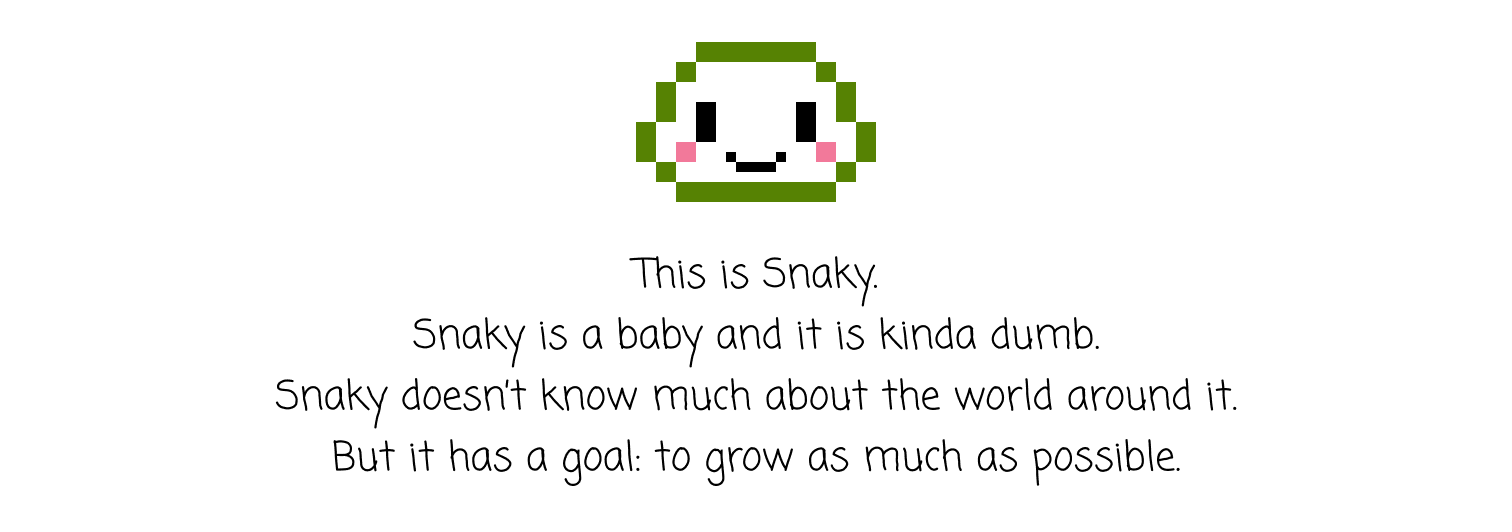

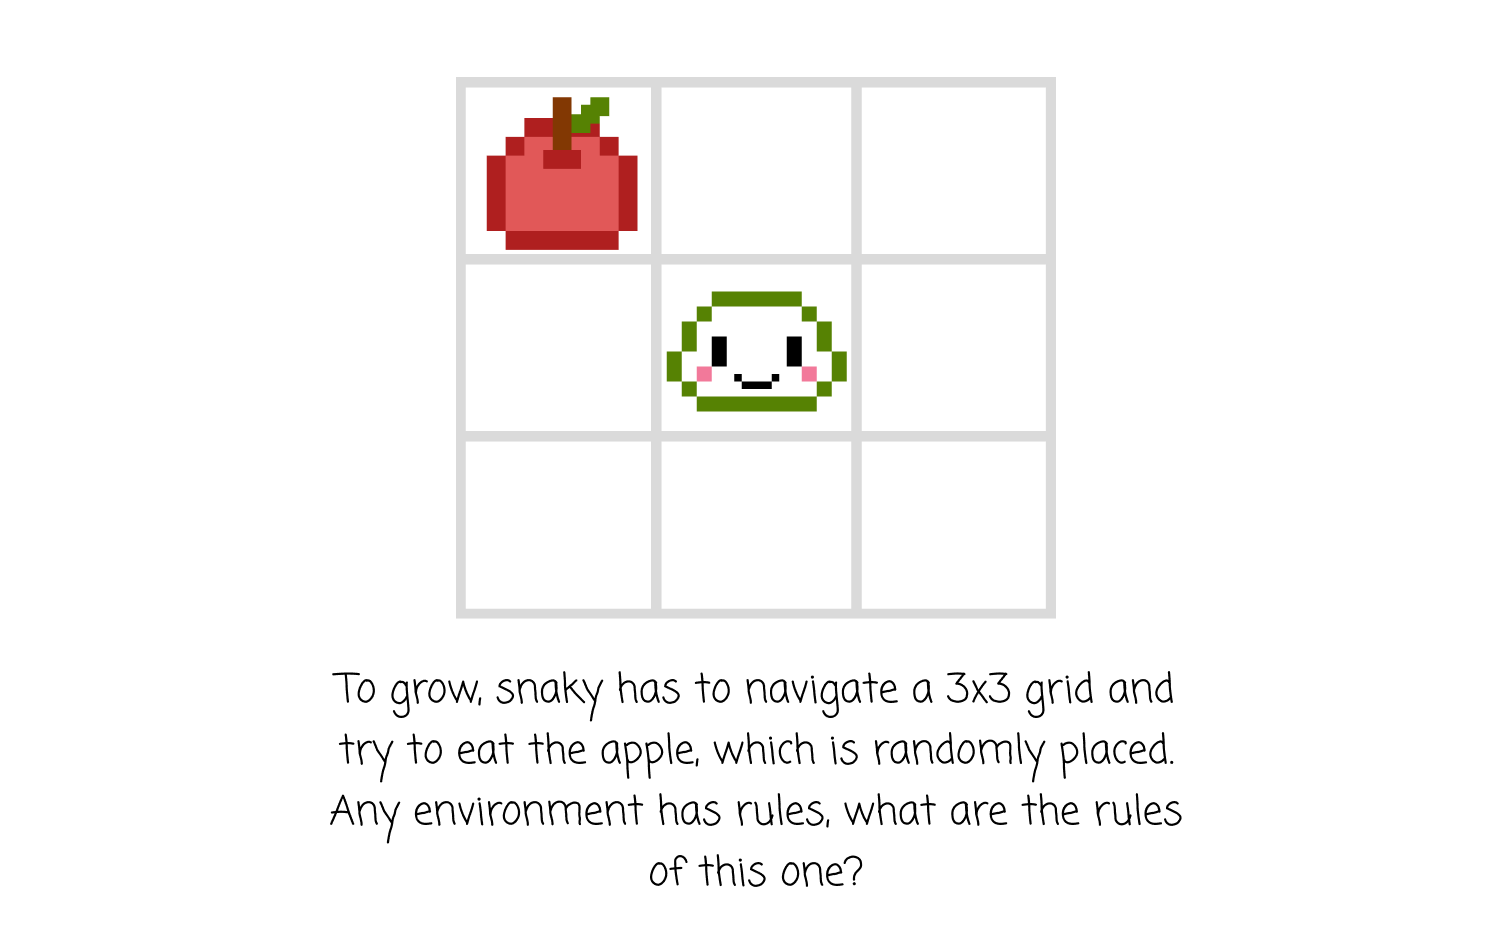

## Game Rules

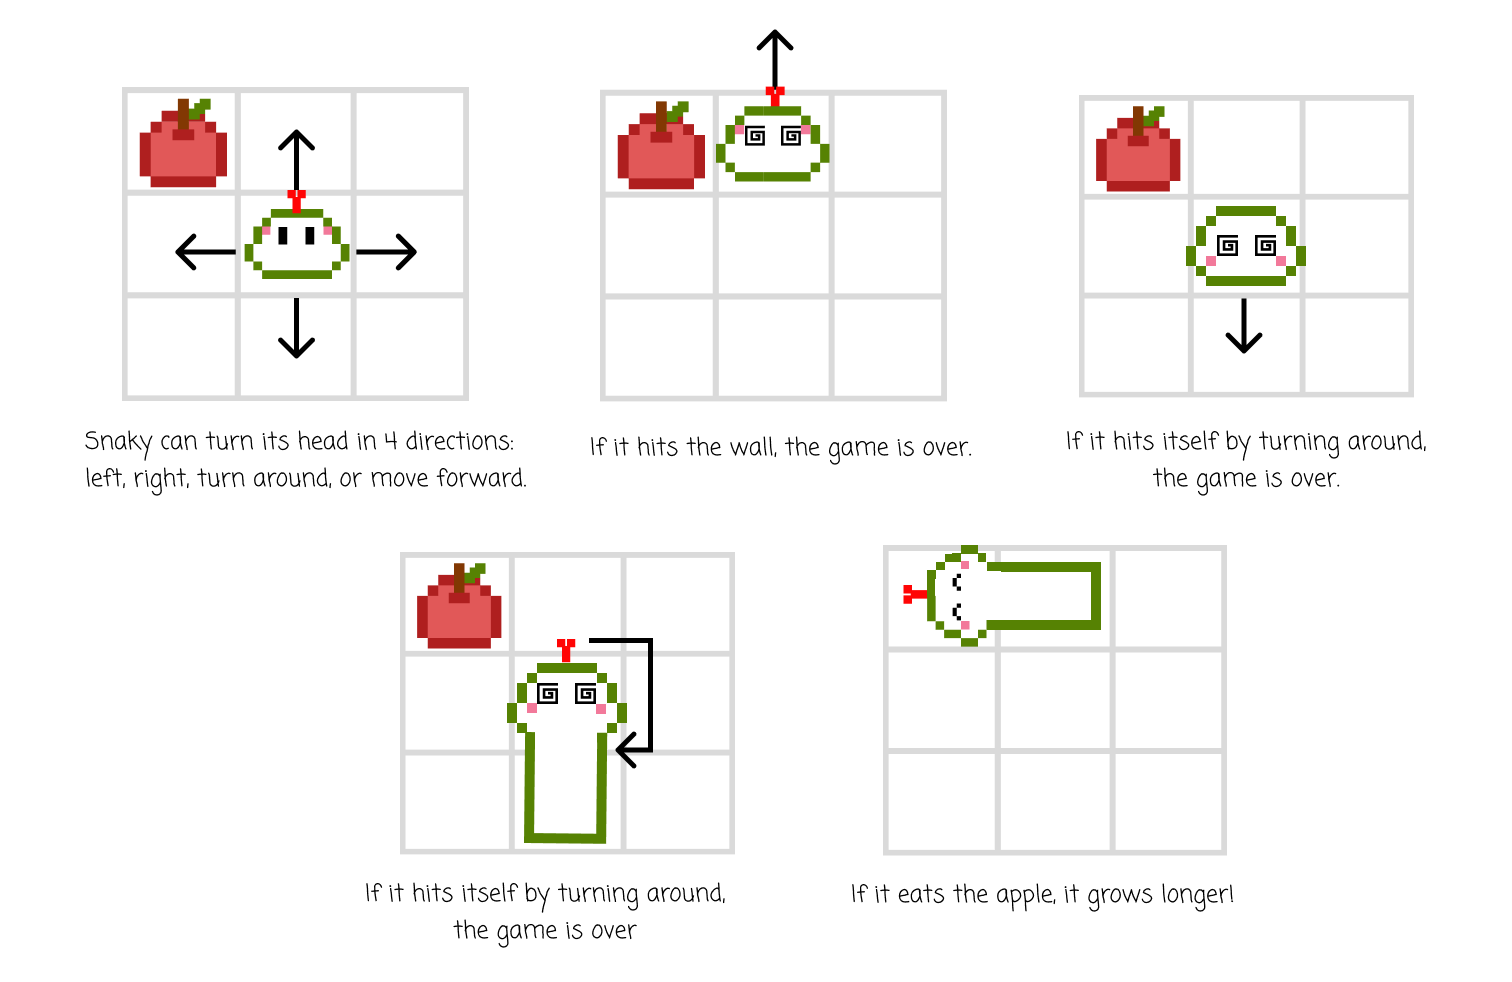

## Game States

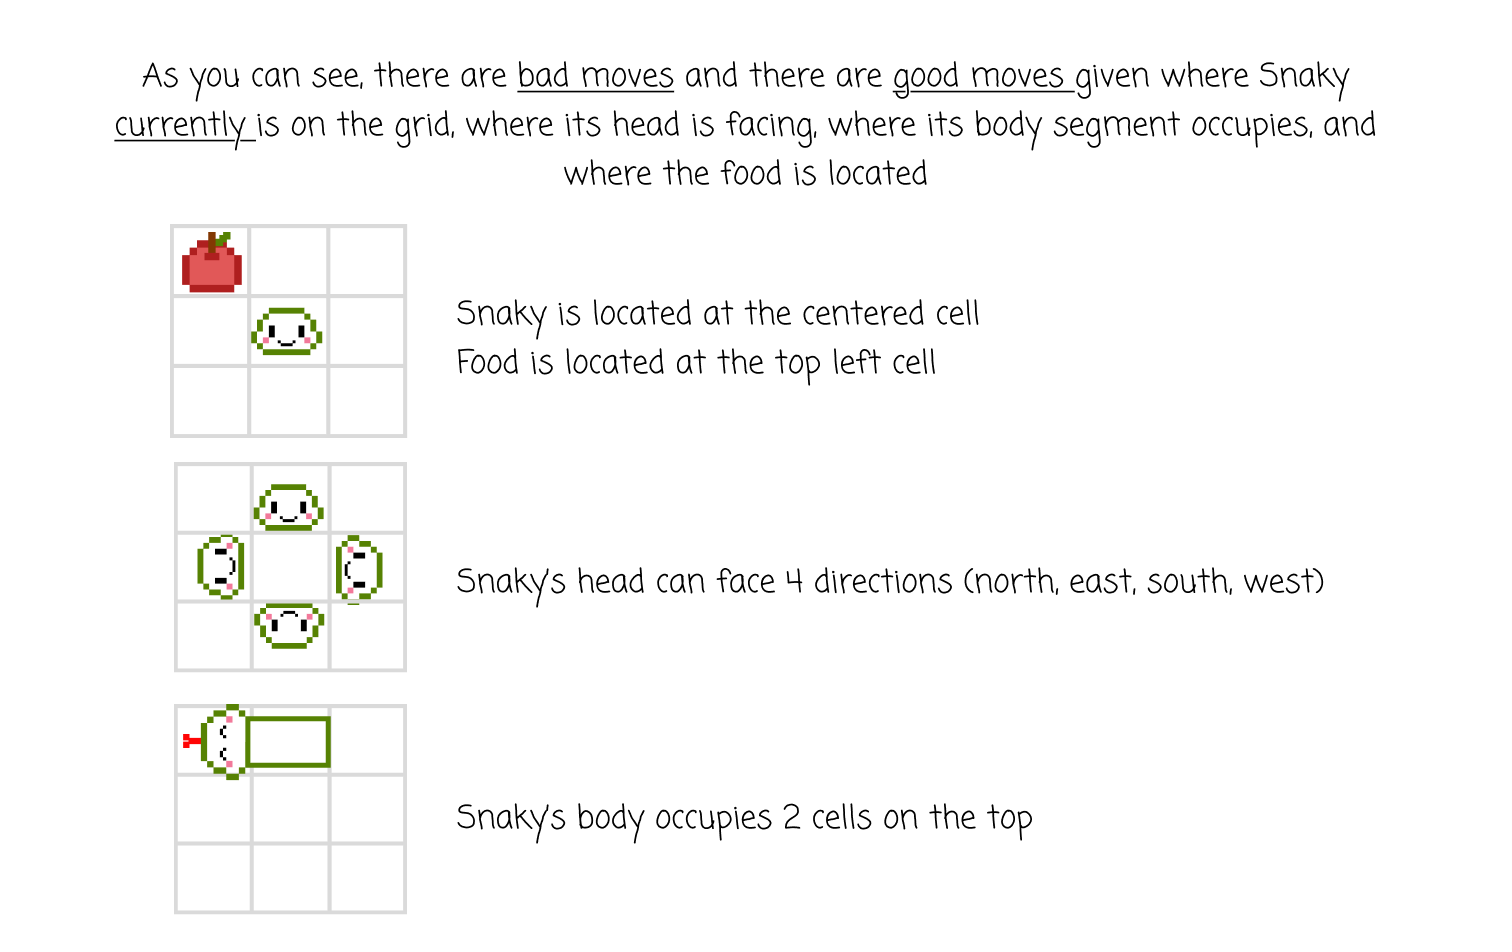

You are tasked with teaching Snaky how to navigate this environment so that it learns which one is a good or bad move given its current state. What would you do?

## Reward vs. Penalty

Given that snaky lives in the computational world,
we need to quantify the reward and penalty for it
to know which is the good and bad move. It's like giving grades to students. For example, imagine Snaky is in the below state:

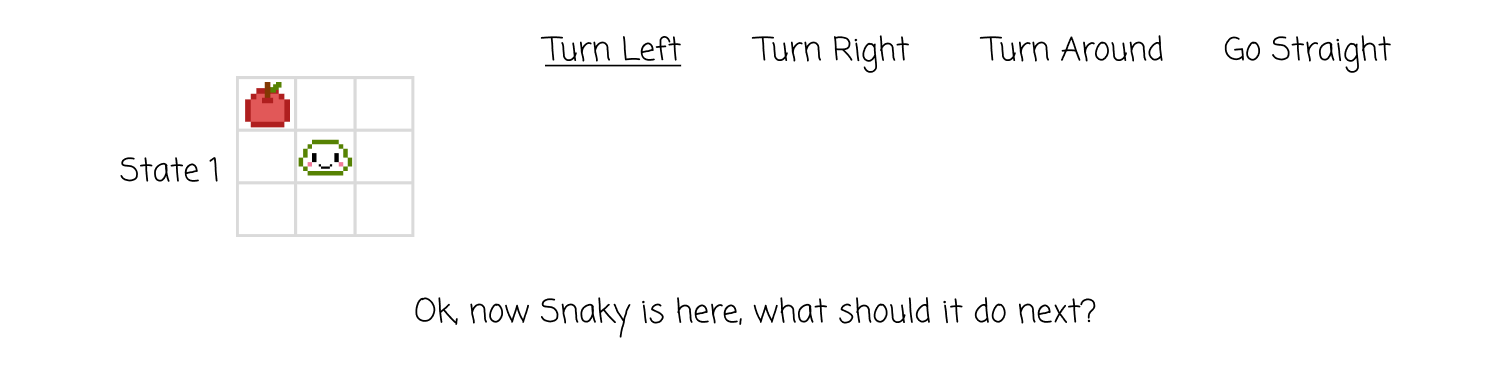

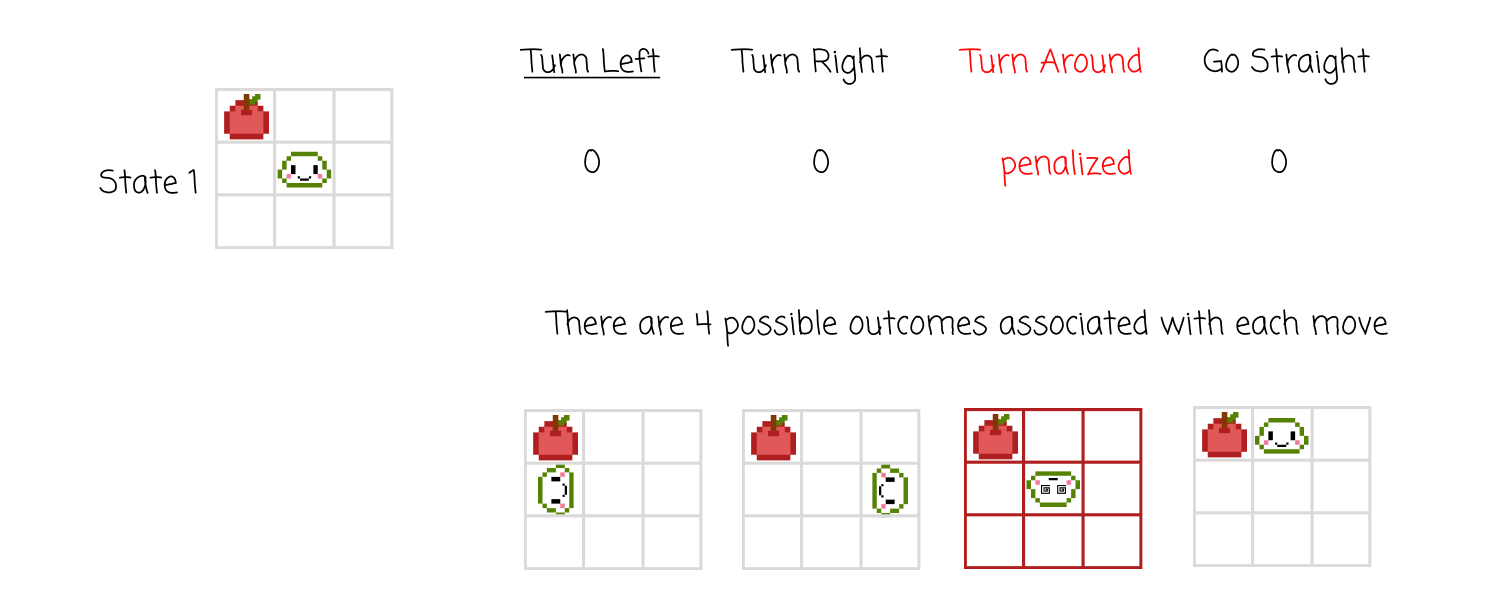

Let's see a few other examples:

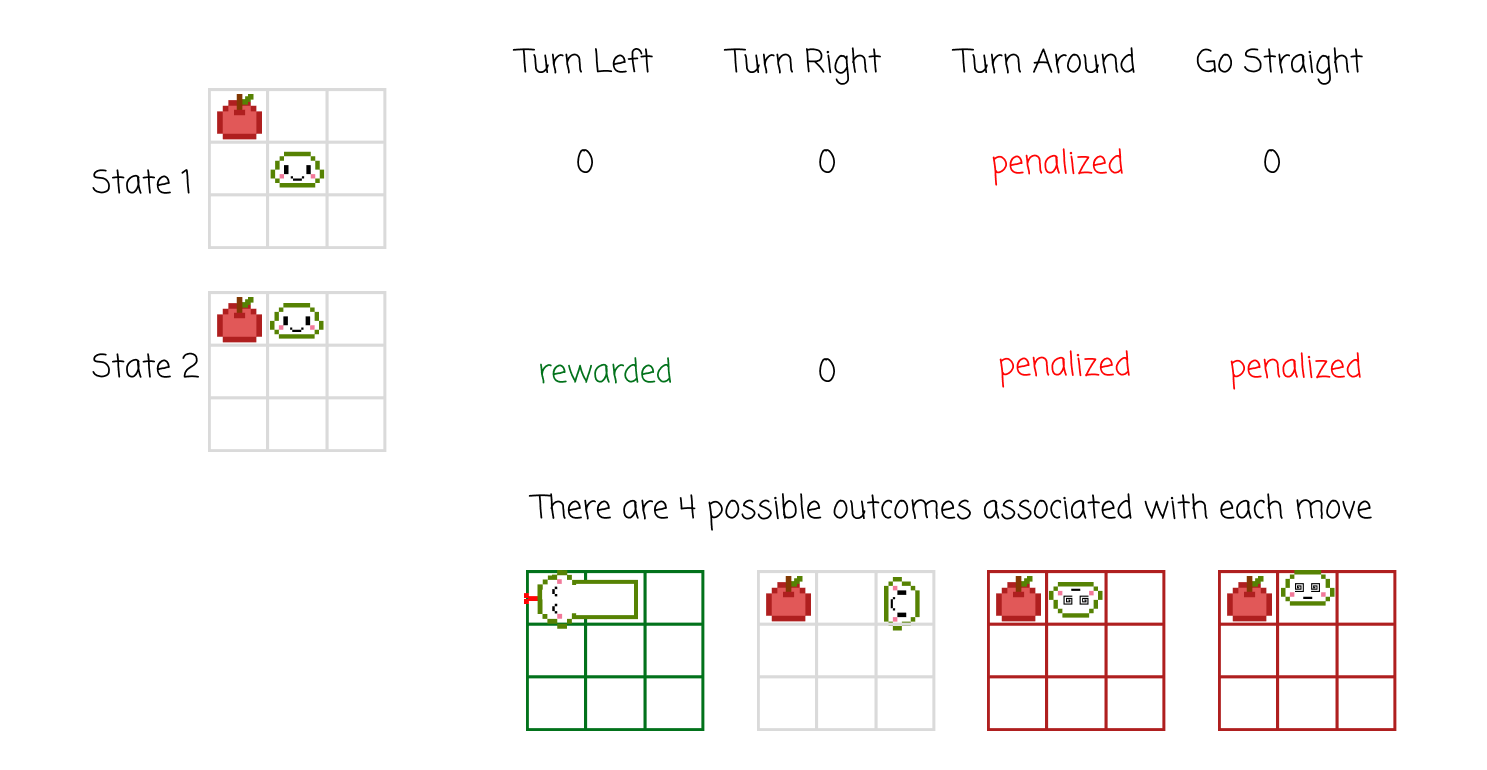

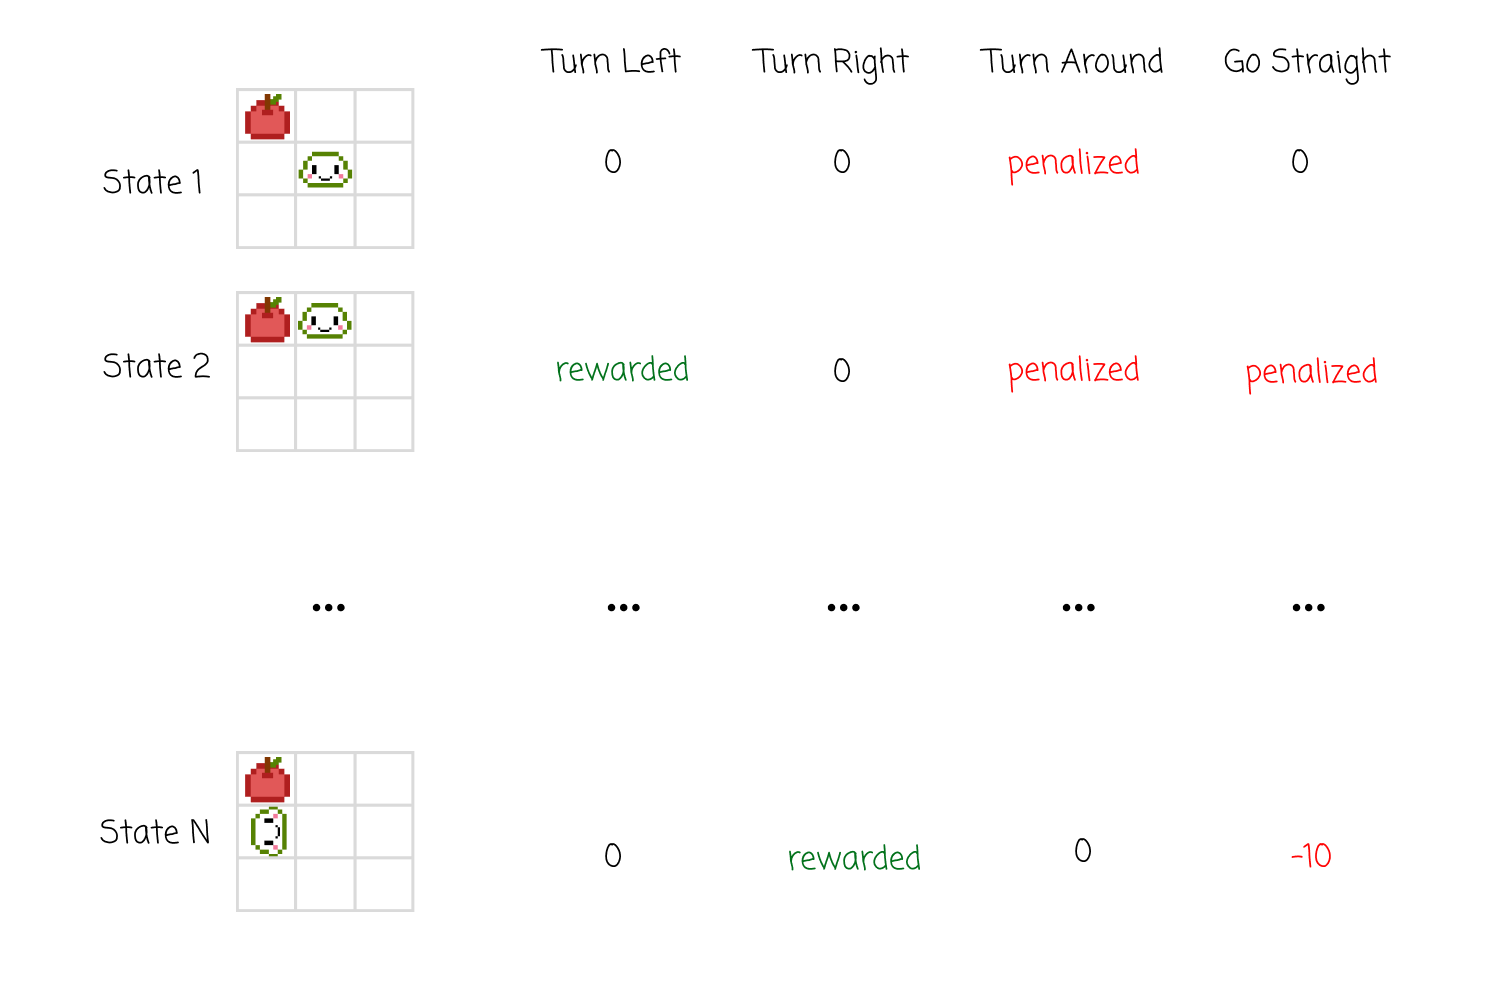

This table acts as Snaky's **memory**. To build the memory on how to navigate this environment, Snaky first needs to learn a lot through **trials and errors**. Once the memory is built, snaky can **look up its memory** to decide which action to take next.

# Generate Valid Game States

> How can we generate all the possible **valid** game states for that table?

A valid game state means the snake's body shape and its head's direction should not violate the rules of the game. Specifically,
1. The snake's body shape must consist of continuous and adjacent segments
2. The snake's head direction should be valid for its location.

Below are some examples of invalid game states:

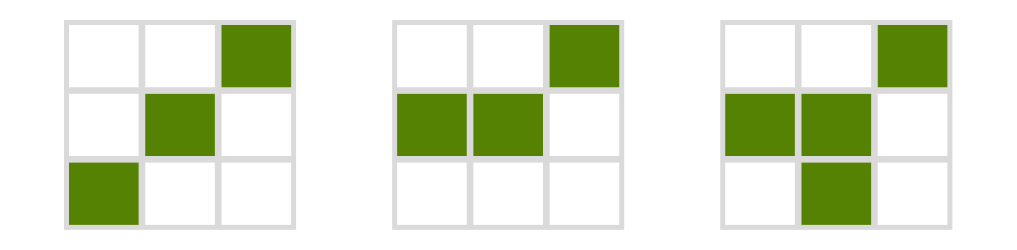
**Figure 1**. *Examples of invalid game states regarding body shape*. The snake's body shapes are disrupted and do not form a continuous adjacent segment.

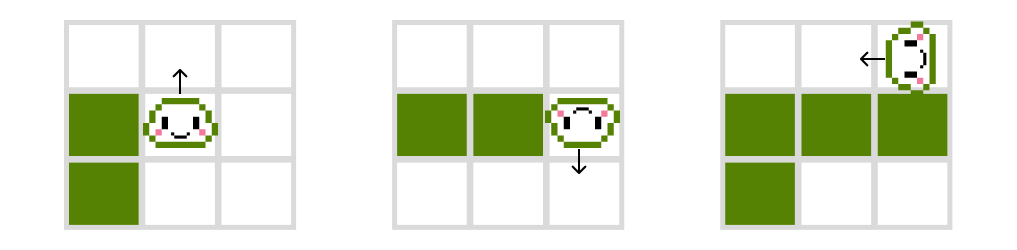
**Figure 2**. *Examples of invalid game states regarding head direction.* The arrows show the snake head's invalid direction. In the first grid, if the snake's head is located on the middle cell for its given shape, then the only valid direction for its head is →. To clarify, the snake can turn its head in the arrow direction in the next time step, but at the given time step, its direction cannot be in that direction - **the direction represents where it's coming from in the previous step**. Similar logic applies to the other two grids.


## Mathematical Formula

In order to enumerate all possible valid game states, we will follow these steps:

1. For each snake length, compute the possible number of shapes (S).
2. For each shape, enumerate all valid placements (P).
3. For each placement, consider all possible head positions and orientations (O), as well as all valid food placements (F).
4. Calculate the total number of valid states (T) for a given length as:

$$ T = \sum_{i=1}^{n=9} (S_{i} \times P_i \times O_i \times F_i) $$




## Recursive Depth-First Search

In [114]:
"""State generation utilities for Q-Learning Snake Game.

This module contains functions to generate all valid game states for a snake game
on a grid of any size. States are represented as tuples of:
(head_position, head_direction, body_tuple, food_position)
"""

from typing import List, Tuple, Set, Dict

In [115]:
def neighbors(cell: Tuple[int, int], grid_size: int):
    """Generate valid neighboring cells within the grid.

    Args:
        cell: (row, col) tuple representing the current cell
        grid_size: size of the grid

    Yields:
        Tuple[int, int]: valid neighboring cells
    """
    r, c = cell

    # Loop through all possible movements: up, down, left, right
    for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        nr, nc = r + dr, c + dc

        # Check if the new position is within the grid boundaries
        if 0 <= nr < grid_size and 0 <= nc < grid_size:
            yield (nr, nc)

In [116]:
def dir_from(from_pos: Tuple[int, int], to_pos: Tuple[int, int]) -> str:
    """Determine direction from one position to another.

    Args:
        from_pos: the coordinates of the starting position
        to_pos: the coordinates of the target position

    Returns:
        str: the direction from from_pos to to_pos ('upward', 'downward', 'rightward', 'leftward')
    """
    dr, dc = to_pos[0] - from_pos[0], to_pos[1] - from_pos[1]

    if dr == -1:
        return 'upward'
    if dr == 1:
        return 'downward'
    if dc == 1:
        return 'rightward'
    return 'leftward'

In [117]:
def generate_connected_placements(length: int, grid_size: int) -> List[Tuple]:
    """Generate all connected placements of a snake of given length on the grid.

    Args:
        length: the length of the snake
        grid_size: size of the grid

    Returns:
        List[Tuple]: list of unique snake placements (as sorted tuples of cells)
    """
    cells = [(r, c) for r in range(grid_size) for c in range(grid_size)]
    placements = set()

    def dfs(path):
        # If the path has reached the desired length, record it
        if len(path) == length:
            placements.add(tuple(sorted(path)))
            return

        # If the path is not yet complete, extend it
        tail = path[-1]
        for nb in neighbors(tail, grid_size):
            if nb not in path:
                dfs(path + [nb])

    # Start DFS from each cell in the grid
    for cell in cells:
        dfs([cell])

    return [tuple(p) for p in placements]

In [118]:
def head_dir_pairs_for_placement(shape_cells: List[Tuple[int, int]], grid_size: int) -> Set:
    """Generate all valid (head_pos, head_dir) pairs for a given snake shape.

    Args:
        shape_cells: a list of (r, c) tuples representing the snake's body cells
        grid_size: size of the grid

    Returns:
        set: a set of (head_pos, head_dir) pairs
    """
    shape_cells = set(shape_cells)
    pairs = set()

    # Special-case single cell: any facing is valid
    if len(shape_cells) == 1:
        only = next(iter(shape_cells))
        for d in ['upward', 'downward', 'rightward', 'leftward']:
            pairs.add((only, d))
        return pairs

    def dfs(path):
        """Recursive DFS to build paths through the shape cells."""
        # If the path covers all shape cells, record the head and direction
        if len(path) == len(shape_cells):
            head, second = path[0], path[1]
            pairs.add((head, dir_from(head, second)))
            return

        # If not complete, extend the path
        tail = path[-1]
        for nb in neighbors(tail, grid_size):
            # Only consider neighbors that are part of the shape and not already in the path
            if nb in shape_cells and nb not in path:
                dfs(path + [nb])

    # Start DFS from each cell in the shape
    for start in shape_cells:
        dfs([start])
    return pairs

In [119]:
def generate_all_valid_states(grid_size: int, actions: List[str]) -> Dict:
    """Generate all valid game states for a given grid size.

    Args:
        grid_size: size of the grid
        actions: list of available actions (used to initialize Q-values)

    Returns:
        Dict: dictionary mapping states to action dictionaries initialized to 0.0
              Format: {(head_pos, head_dir, body_tuple, food_pos): {action: 0.0, ...}, ...}
    """
    game_states = {}
    food_positions = [(x, y) for x in range(grid_size) for y in range(grid_size)]

    for length in range(1, grid_size * grid_size + 1):
        placements = generate_connected_placements(length, grid_size)

        for placement in placements:
            pairs = head_dir_pairs_for_placement(placement, grid_size)

            for head_pos, head_dir in pairs:
                body_tuple = tuple(placement)

                for food_pos in food_positions:
                    if food_pos not in placement:
                        state = (head_pos, head_dir, body_tuple, food_pos)
                        game_states[state] = {action: 0.0 for action in actions}

    return game_states

In [120]:
def count_states_by_length(game_states: Dict) -> Dict[int, int]:
    """Count the number of valid states for each snake length.

    Args:
        game_states: dictionary of game states

    Returns:
        Dict[int, int]: {length: count, ...}
    """
    length_counts = {}

    for (head_pos, head_dir, body_tuple, food_pos) in game_states.keys():
        length = len(body_tuple)
        length_counts[length] = length_counts.get(length, 0) + 1

    return length_counts

In [121]:
def count_states_by_length(game_states: Dict) -> Dict[int, int]:
    """Count the number of valid states for each snake length.

    Args:
        game_states: dictionary of game states

    Returns:
        Dict[int, int]: {length: count, ...}
    """
    length_counts = {}

    for (head_pos, head_dir, body_tuple, food_pos) in game_states.keys():
        length = len(body_tuple)
        length_counts[length] = length_counts.get(length, 0) + 1

    return length_counts

In [122]:
GRID_SIZE = 3
HEAD_DIRECTIONS = ['upward', 'downward', 'rightward', 'leftward']
HEAD_POSITIONS = [(x, y) for x in range(GRID_SIZE) for y in range(GRID_SIZE)]
FOOD_POSITIONS = [(x, y) for x in range(GRID_SIZE) for y in range(GRID_SIZE)]

In [123]:
GAME_STATES = generate_all_valid_states(GRID_SIZE, HEAD_DIRECTIONS)
length_counts = count_states_by_length(GAME_STATES)
print(f"Generated {len(GAME_STATES)} valid game states.")
print("\nValid states by snake length:")
print("=" * 40)
for length in sorted(length_counts.keys()):
    print(f"Length {length}: {length_counts[length]} states")
print("=" * 40)
print(f"Total: {sum(length_counts.values())} states")

Generated 2032 valid game states.

Valid states by snake length:
Length 1: 288 states
Length 2: 168 states
Length 3: 264 states
Length 4: 400 states
Length 5: 352 states
Length 6: 312 states
Length 7: 168 states
Length 8: 80 states
Total: 2032 states


# Q-Learning Algorithm

The algorithm we're going to use trains Snaky to learn through trials and errors is called Q-learning, which iteratively update the Q-table (Snaky's memory):

$$
Q(S_t, A_t) ← Q(S_t, A_t) + α[R_{t+1} + γ max_{a} Q(S_{t+1}, a) - Q(S_t,A_t)]
$$

Yes, it's this scary formula that helps Snaky learn! Let's unpack each symbol one by one:
1. $Q(S_t, A_t)$ is the table that stores all values of state-action pairs (i.e., the agent's memory)
2. $\alpha$ (0-1) is the learning rate (i.e., how much should we update the value)
3. $γ$ (0-1) is the discounting factor (i.e., how much we value future rewards compared to immediate rewards. Higher γ = more patient/strategic, lower γ = more greedy/shortsighted)
4. $max_{a} Q(S_{t+1}, a)$ is the maximum value considering all future actions

You might ask why don't we just directly add values like -10 for penalty and +10 for reward at every time step? Why bother applying this "complex" algorithm?

> It's all about the **expected future return**, not about immediate rewards. At every step, Snaky needs to answer the question: "If I choose this action now, how good will my future be on average?"

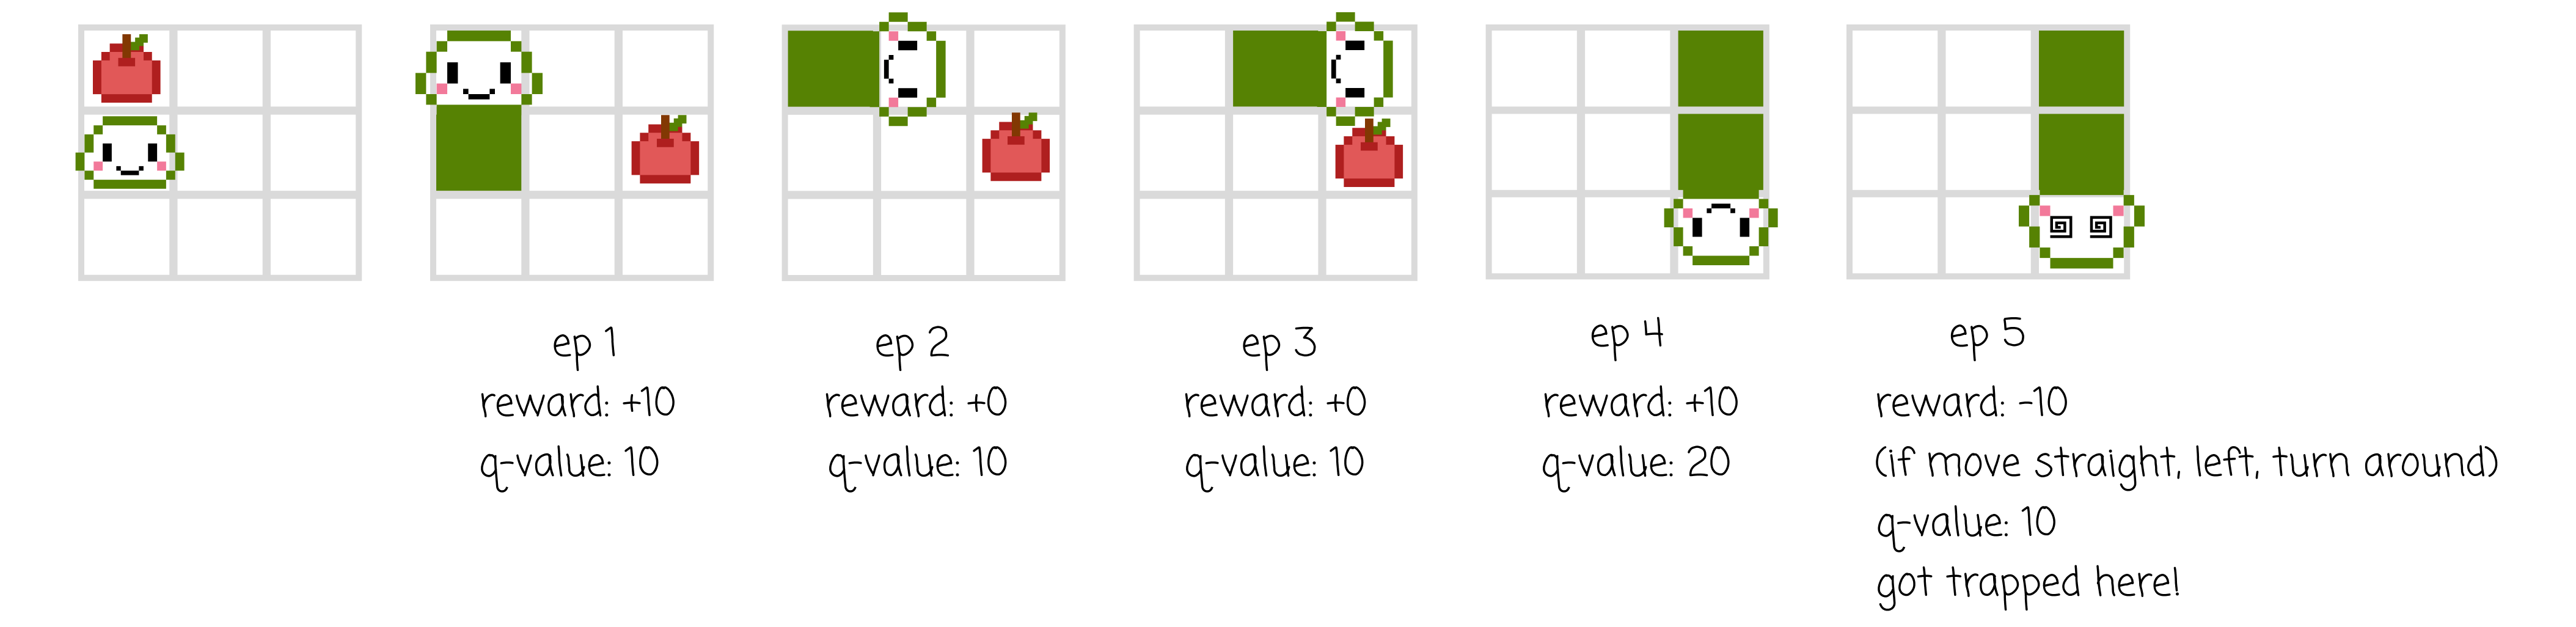

In this example, if we add the immediate rewards to update the Q-table, the snake will get trapped in the corner without learning that turning right at (0,1) is a dangerous move because it will always return 0. But if we apply Q-learning, after a few learning episodes, the value will get slower and the snake will eventually learn that this is not a good move given its current state


## Explore vs. Exploit

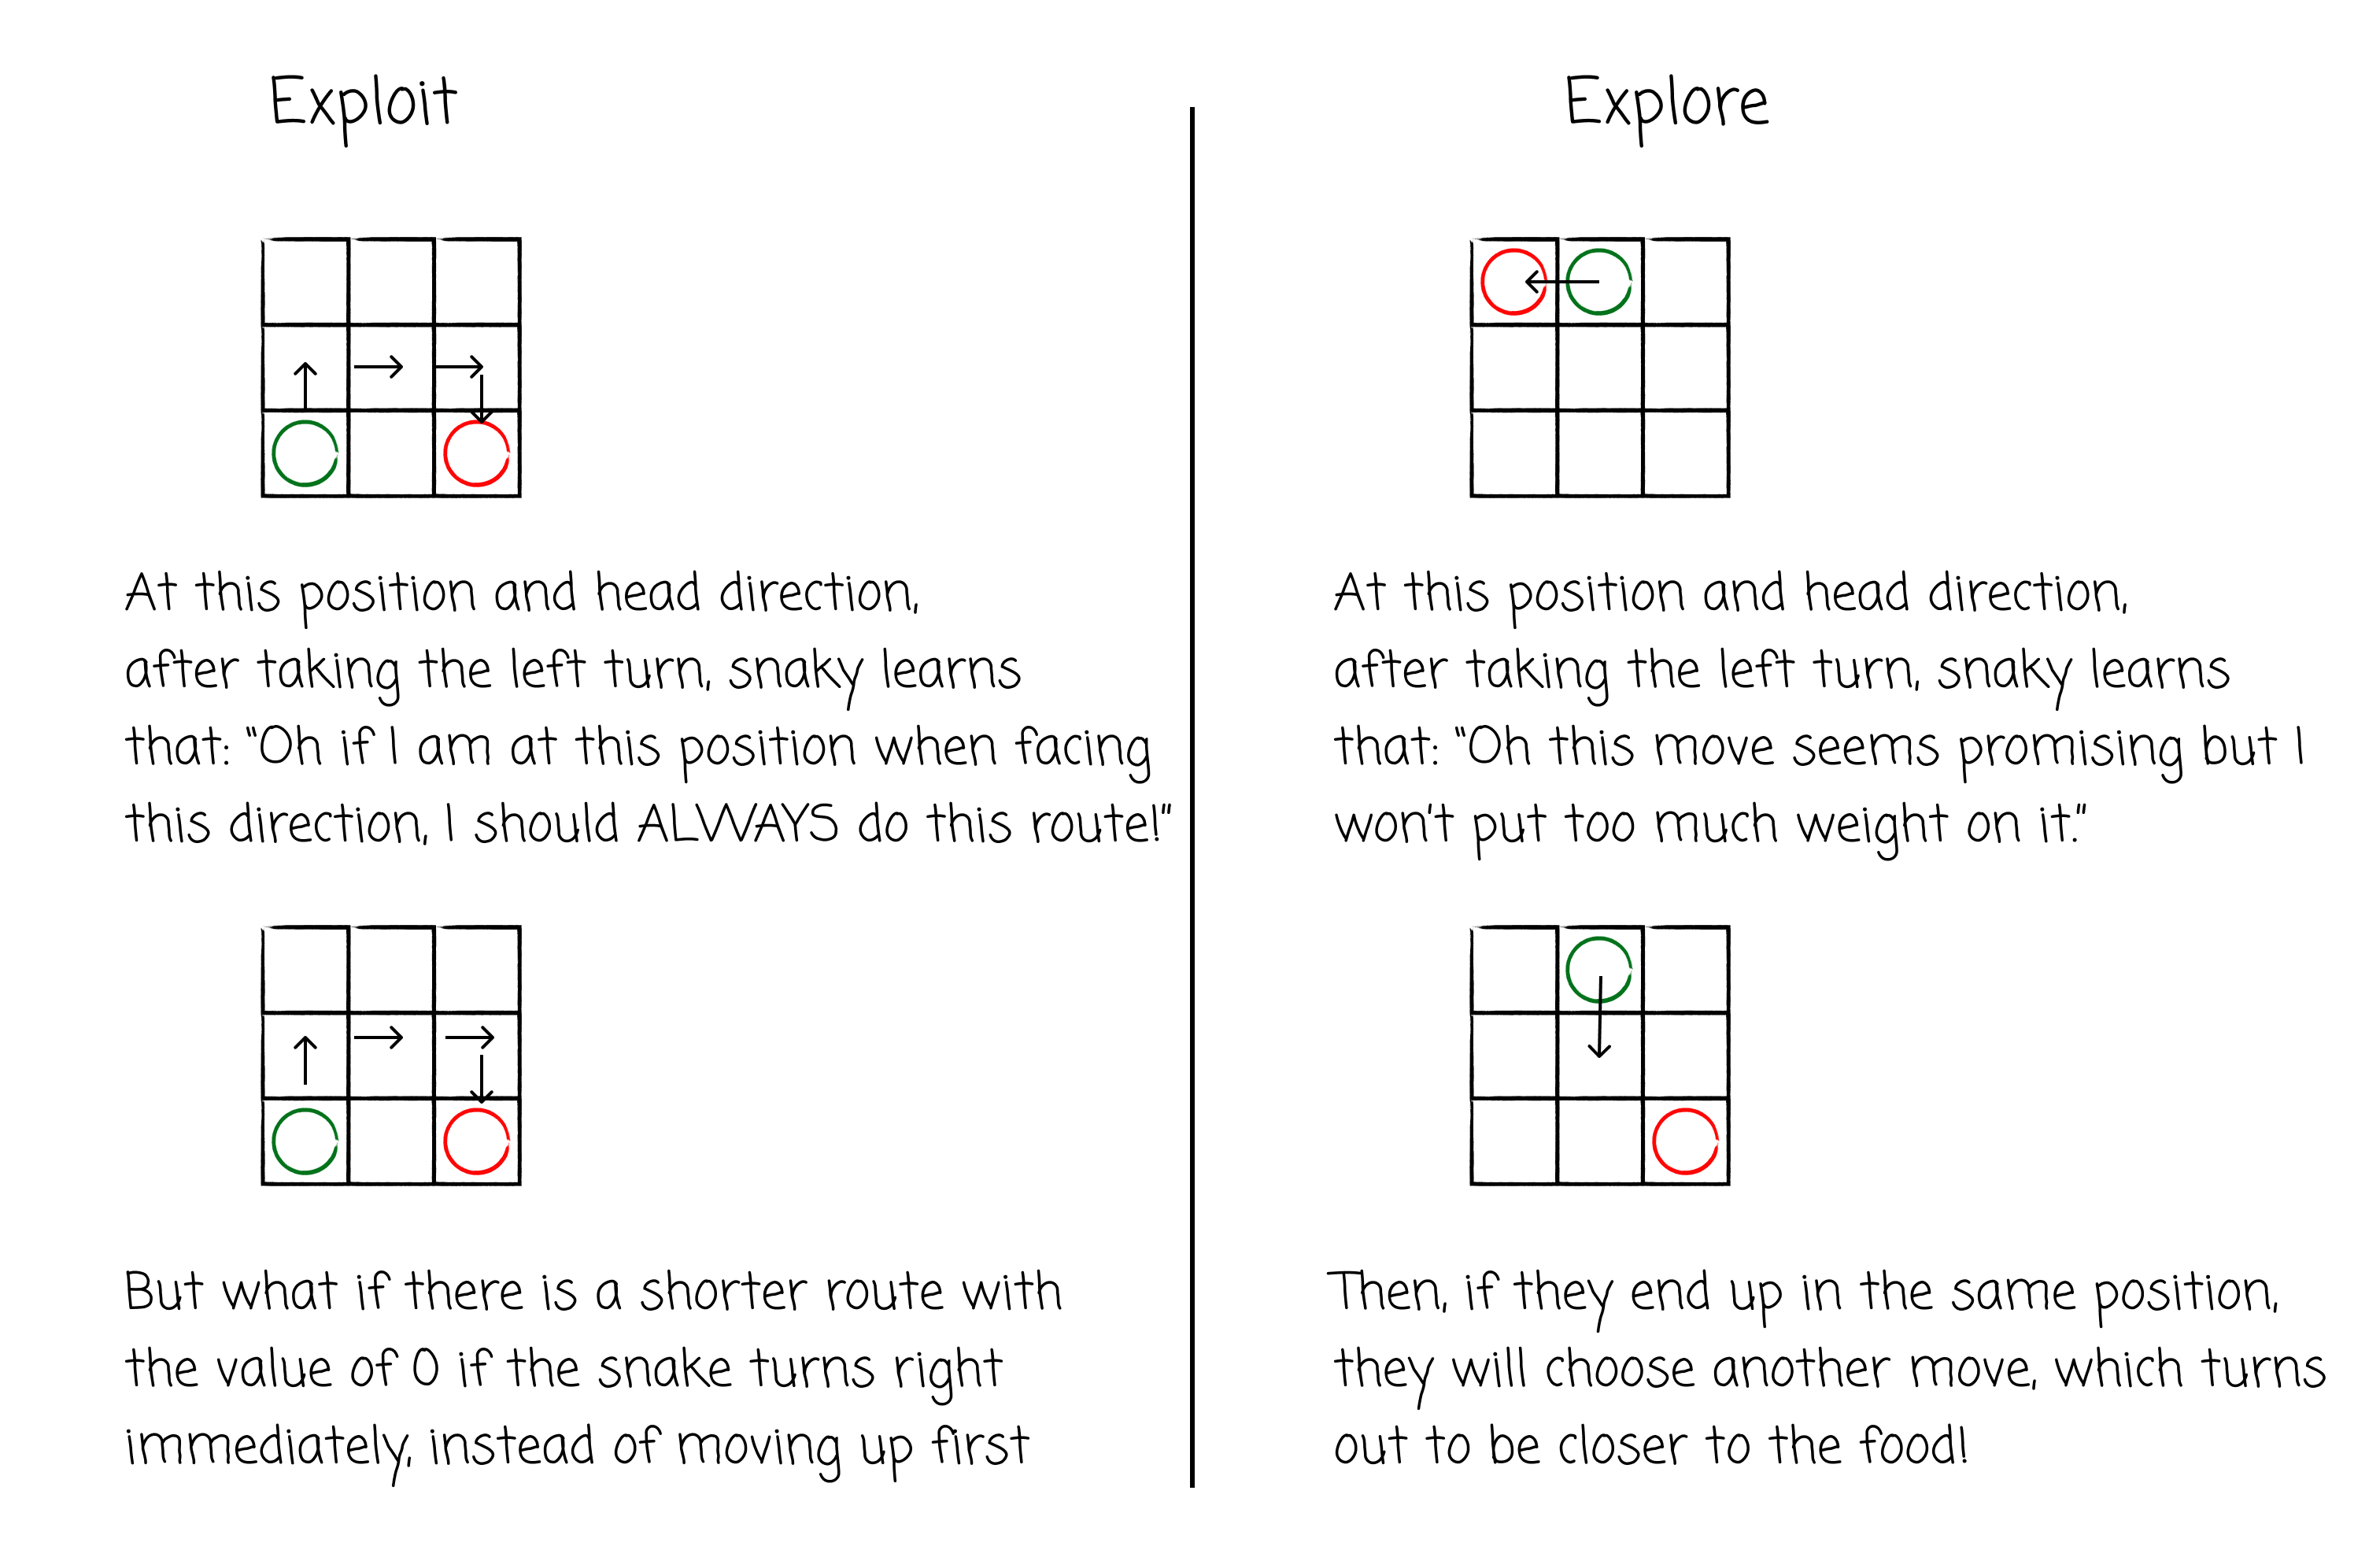

## Code

In [124]:
DIRECTIONS = {
    'upward': (-1, 0),
    'downward': (1, 0),
    'leftward': (0, -1),
    'rightward': (0, 1)
}

def get_current_direction(snake_positions):
    """Determine snake's current direction from head and neck position."""
    if len(snake_positions) < 2:
        return 'rightward'  # Default

    head, neck = snake_positions[0], snake_positions[1]
    dr, dc = head[0] - neck[0], head[1] - neck[1]

    if dr == -1: return 'upward'
    if dr == 1: return 'downward'
    if dc == 1: return 'rightward'
    return 'leftward'

def get_state_representation(game):
    """Convert GameLogic to state tuple: (head_pos, head_dir, body_tuple, food_pos)."""
    head_pos = game.Snake.snake_positions[0]
    head_dir = get_current_direction(game.Snake.snake_positions)

    body_tuple = tuple(game.Snake.snake_positions)
    food_pos = game.GameEnvironment.food_pos

    return (head_pos, head_dir, body_tuple, food_pos)

def get_direction(action, current_direction):
    """Convert relative action to absolute direction tuple."""
    turns = {
        'upward': {
            'turn_left': 'leftward',
            'go_straight': 'upward',
            'turn_right': 'rightward',
            'turn_around': 'downward',
        },
        'downward': {
            'turn_left': 'rightward',
            'go_straight': 'downward',
            'turn_right': 'leftward',
            'turn_around': 'upward',
        },
        'leftward': {
            'turn_left': 'downward',
            'go_straight': 'leftward',
            'turn_right': 'upward',
            'turn_around': 'rightward',
        },
        'rightward': {
            'turn_left': 'upward',
            'go_straight': 'rightward',
            'turn_right': 'downward',
            'turn_around': 'leftward',
        },
    }
    new_dir = turns[current_direction][action]
    return DIRECTIONS[new_dir]

In [125]:
import random
from typing import Dict, Tuple

class QLearningAgent:
    REWARD_FOOD = 10
    REWARD_DEATH = -10
    REWARD_STEP = 0

    def __init__(self,
                 actions: list,
                 learning_rate: float,
                 epsilon: float,
                 gamma: float,
                 grid_size: int,
                 num_episodes: int):
        """Define the attributes of the learning agent

        Args:
            actions (list): a list of possible actions
            learning_rate (float): how much to update the q-values at each step
            epsilon (float): the probability of choosing a random action (exploration)
            gamma (float): the discounting factor for future rewards
            grid_size (int): the size of the game grid
            num_episodes (int): the number of training episodes

        Returns: None
        """
        self.q_table = {}
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.gamma = gamma
        self.actions = actions
        self.grid_size = grid_size
        self.num_episodes = num_episodes

    def set_q_table(self) -> Dict:
        # Initialize the Q-table with all valid game states.
        self.q_table = generate_all_valid_states(self.grid_size, self.actions)

        # Create a Q-table with all the state-action pairs initialized to 0.0
        for action in self.actions:
            for state in self.q_table:
                self.q_table[state][action] = 0.0
        return self.q_table

    def get_q_value(self, state: Tuple, action: str) -> float:
        return self.q_table.get(state, {}).get(action, 0.0)

    def choose_action(self, state: Tuple, epsilon: float) -> str:
        # Epsilon-greedy action selection
        if random.uniform(0,1) < epsilon:
            return random.choice(self.actions)
        else:
            # Initialize state in Q-table if not present (defensive programming)
            if state not in self.q_table:
                self.q_table[state] = {a: 0.0 for a in self.actions}
                
            # Get all the q-values (state-action) for the current state
            state_actions = self.q_table[state]

            # Select the action with the highest q-value
            max_q = max(state_actions.values())

            # In case of multiple actions with the same max q-value, choose randomly among them
            best_actions = [action for action, q in state_actions.items() if q == max_q]
            
            # Use deterministic tie-breaking: always pick the first action in the original actions list
            for action in self.actions:
                if action in best_actions:
                    return action
                
            return self.actions[0]

    def update_q_value(self, state: Tuple, action: str, reward: int, next_state: Tuple) -> float:
        """Update the Q-value for a given state-action pair based on the received reward and the maximum future Q-value.

        Args:
            state (Tuple): the current state
            action (str): the action taken
            reward (int): the reward received after taking the action
            next_state (Tuple): the state resulting from taking the action
        """
        # Initialize state in Q-table if not present
        if state not in self.q_table:
            self.q_table[state] = {a: 0.0 for a in self.actions}

        current_q_value = self.get_q_value(state, action)
        max_future_q = max(self.q_table.get(next_state, {}).values(), default=0.0)

        # Q-learning formula
        new_q_value = current_q_value + self.learning_rate * (reward + self.gamma * max_future_q - current_q_value)

        # Update the Q-table
        self.q_table[state][action] = new_q_value

        return self.q_table[state][action]

In [126]:
import random
import os

class Snake:
    def __init__(self, initial_length = 1) -> None:
        self.length = initial_length
        self.just_ate_food = False
        self.snake_positions = [(1, 1)]

class GameEnvironment:
    def __init__(self, grid_size: int) -> None:
        self.grid_size = grid_size
        # Backwards-compatible alias used throughout the codebase
        self.size = grid_size
        self.score = 0
        self.grid = [[0] * grid_size for _ in range(grid_size)]
        self.food_pos = (grid_size // 2, grid_size // 2)

class GameLogic():
    # make sure that the down is 1 and up is -1 for the row index
    DOWN = (1, 0)
    UP = (-1, 0)
    LEFT = (0, -1)
    RIGHT = (0, 1)

    def __init__(self, grid_size, score_history = []) -> None:
        self.GameEnvironment = GameEnvironment(grid_size)
        self.Snake = Snake()
        self.directions = [self.DOWN, self.UP, self.LEFT, self.RIGHT]
        self.highest_score = self.load_high_score()

    def load_high_score(self):
        if os.path.exists("highscore.txt"):
            with open("highscore.txt", "r") as f:
                try:
                    return int(f.read().strip())
                except ValueError:
                    return 0
        return 0

    def save_high_score(self):
        if self.GameEnvironment.score > self.highest_score:
            self.highest_score = self.GameEnvironment.score
            with open("highscore.txt", "w") as f:
                f.write(str(self.highest_score))

    def place_food(self):
        # Place food at a random position in the grid where the snake is not located
        empty = [
            (r, c)
            for r in range(self.GameEnvironment.grid_size)
            for c in range(self.GameEnvironment.grid_size)
            if (r, c) not in self.Snake.snake_positions
        ]
        self.GameEnvironment.food_pos = random.choice(empty)

    def move(self, direction):
        # Get the snake's head position (row, column)
        head = self.Snake.snake_positions[0]

        # Calculate the new head position based on the direction
        new_head = (head[0] + direction[0], head[1] + direction[1])

        # Check self-collision
        if new_head in self.Snake.snake_positions[1:]:
            raise Exception("Game Over: Self-collision")

        # Check wall-collision
        if not (0 <= new_head[0] < self.GameEnvironment.grid_size and 0 <= new_head[1] < self.GameEnvironment.grid_size):
            raise Exception("Game Over: Wall-collision")

        # Add the new head position to the snake's positions
        self.Snake.snake_positions.insert(0, new_head)

        # Check if the snake has eaten food
        if new_head == self.GameEnvironment.food_pos:
            self.Snake.just_ate_food = True
            self.GameEnvironment.score += 1
            self.place_food()

        # If the snake has not just eaten food, remove the last position
        if not self.Snake.just_ate_food:
            self.Snake.snake_positions.pop()
        else:
            self.Snake.just_ate_food = False

    def stop_game(self) -> int:
        # update the highest score
        self.save_high_score()
        return self.GameEnvironment.score

    def get_state(self):
        return {
            "snake": self.Snake.snake_positions,
            "food": self.GameEnvironment.food_pos,
            "score": self.GameEnvironment.score,
            "grid_size": self.GameEnvironment.size
        }

    def render(self):
        size = self.GameEnvironment.grid_size
        grid = [['.'] * size for _ in range(size)]

        for r, c in self.Snake.snake_positions:
            grid[r][c] = 'S'

        fr, fc = self.GameEnvironment.food_pos
        grid[fr][fc] = 'F'

        for row in grid:
            print(' '.join(row))
        print()

Training (epsilon=0.1): 100%|██████████| 20000/20000 [00:05<00:00, 3934.07it/s]


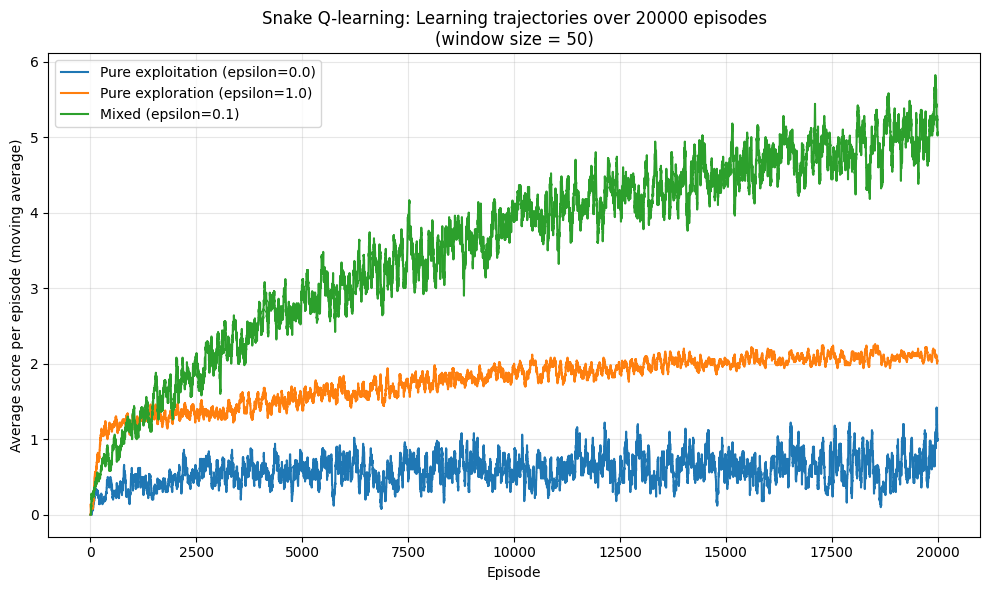

In [127]:
import random
from typing import List, Dict
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters
ACTIONS = ["turn_left", "go_straight", "turn_right", "turn_around"]
LEARNING_RATE = 0.2
GRID_SIZE = 4
NUM_EPISODES = 20000
MAX_STEPS_PER_EPISODE = 200

# Moving-average window for smoothing the curves
MOVING_AVG_WINDOW = 50

def run_training(
    train_epsilon: float,
    gamma: float,
    num_episodes: int = NUM_EPISODES,
    grid_size: int = GRID_SIZE,
    learning_rate: float = LEARNING_RATE,
) -> List[float]:
    """
    Train a fresh Q-learning agent for a given training epsilon and,
    after each training episode, run a separate evaluation episode
    with epsilon = 0.0. Returns the per-episode evaluation scores
    over num_episodes.

    This mirrors the logic in train.py but without visualization or Q-table I/O.
    Training uses epsilon = train_epsilon, evaluation uses epsilon = 0.0
    (pure exploitation of the learned Q-table).
    """
    agent = QLearningAgent(
        actions=ACTIONS,
        learning_rate=learning_rate,
        epsilon=train_epsilon,
        gamma=gamma,
        grid_size=grid_size,
        num_episodes=num_episodes,
    )

    # Start from a fresh Q-table for each training run
    agent.set_q_table()

    eval_scores: List[float] = []

    for episode in tqdm(
        range(num_episodes), desc=f"Training (epsilon={train_epsilon})"
    ):
        # -------- Training episode (epsilon = train_epsilon) --------
        game = GameLogic(grid_size=agent.grid_size)
        game.place_food()

        steps = 0
        while True:
            steps += 1
            current_state = get_state_representation(game)
            action = agent.choose_action(current_state, train_epsilon)
            current_dir = get_current_direction(game.Snake.snake_positions)
            direction = get_direction(action, current_dir)

            try:
                old_score = game.GameEnvironment.score
                game.move(direction)
                new_score = game.GameEnvironment.score

                # Reward structure consistent with train.py
                if new_score > old_score:
                    reward = 10  # Ate food
                else:
                    reward = 0  # Normal step

                next_state = get_state_representation(game)

            except Exception as e:
                if "Wall" in str(e):
                    reward = -10
                elif "Self" in str(e):
                    reward = -10
                else:
                    reward = -10

                next_state = current_state  # Terminal state
                agent.update_q_value(current_state, action, reward, next_state)
                break

            # Update Q-value for non-terminal transition
            agent.update_q_value(current_state, action, reward, next_state)

            if steps >= MAX_STEPS_PER_EPISODE:
                break

        # -------- Evaluation episode (epsilon = 0.0, pure exploitation) --------
        eval_game = GameLogic(grid_size=agent.grid_size)
        eval_game.place_food()

        eval_steps = 0
        while True:
            eval_steps += 1
            eval_state = get_state_representation(eval_game)
            eval_action = agent.choose_action(eval_state, 0.0)
            eval_current_dir = get_current_direction(eval_game.Snake.snake_positions)
            eval_direction = get_direction(eval_action, eval_current_dir)

            try:
                eval_game.move(eval_direction)
            except Exception:
                # Game over; record evaluation score and stop this eval episode
                break

            if eval_steps >= MAX_STEPS_PER_EPISODE:
                break

        eval_scores.append(eval_game.GameEnvironment.score)

    return eval_scores


def moving_average(values: List[float], window_size: int) -> List[float]:
    """
    Compute a simple moving average over the given values.
    The output list has the same length as the input list.
    """
    if not values or window_size <= 1:
        return values

    averaged: List[float] = []
    cumulative_sum = 0.0

    for i, v in enumerate(values):
        cumulative_sum += v
        if i >= window_size:
            cumulative_sum -= values[i - window_size]
            averaged.append(cumulative_sum / window_size)
        else:
            averaged.append(cumulative_sum / (i + 1))

    return averaged


def plot_learning_trajectories(results: Dict[str, List[float]]) -> None:
    """
    Plot smoothed average score per episode for each epsilon regime.
    """
    episodes = list(range(1, NUM_EPISODES + 1))

    plt.figure(figsize=(10, 6))

    for label, scores in results.items():
        smoothed = moving_average(scores, MOVING_AVG_WINDOW)
        plt.plot(episodes, smoothed, label=label)

    plt.xlabel("Episode")
    plt.ylabel("Average score per episode (moving average)")
    plt.title(
        f"Snake Q-learning: Learning trajectories over {NUM_EPISODES} episodes\n"
        f"(window size = {MOVING_AVG_WINDOW})"
    )
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("learning_trajectories.png", dpi=200)
    # Uncomment the next line if you want an interactive window when running locally
    # plt.show()


def main() -> None:
    # Make runs reproducible
    random.seed(42)

    epsilon_configs = {
        "Pure exploitation (epsilon=0.0)": 0.0,
        "Pure exploration (epsilon=1.0)": 1.0,
        "Mixed (epsilon=0.1)": 0.1,
    }

    results: Dict[str, List[float]] = {}

    for label, eps in epsilon_configs.items():
        scores = run_training(train_epsilon=eps, gamma=0.5, num_episodes=NUM_EPISODES)
        results[label] = scores

    plot_learning_trajectories(results)


if __name__ == "__main__":
    main()
